# Problem 2 - Policy and Value Iteration
---

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time

In [12]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.1 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 17.0 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.9 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 13.3 MB/s eta 0:00:00


## Util methods to represent the grid (do not modify)
#### You do not need modify any of these methods to complete Problem 2

In [15]:
# Maze state is represented as a 2-element NumPy array: (Y, X). Increasing Y is South.
grid = [
    'o.x.u',
    '..y..',
    '..y.*',
    '..z..']
topology = np.array([list(row) for row in grid])
flat_topology = topology.ravel()
rewards = {'.': 0, '*': 50, 'o': 4, 'u': 20, 'x': -10, 'y': -50,'z': -20}

row_count = len(grid) # 4
col_count = len(grid[0]) # 5
shape = (row_count, col_count) # (4, 5)

# Possible actions, expressed as (delta-y, delta-x)
directions="NSEW"
maze_actions = {
    'N': np.array([-1, 0]),
    'S': np.array([1, 0]),
    'E': np.array([0, 1]),
    'W': np.array([0, -1]),
}
actions = [maze_actions[direction] for direction in directions]


# Returns true if pos (y,x) is out of bounds
def is_wall(pos):
    (y, x) = pos
    return (y < 0 or y >= row_count or x < 0 or x >= col_count)

# Input is a flattened state, returns the reward at that state
def get_reward(state):
    assert (state in range(num_states)), f"get_reward: State was not an integer representing an in-bounds state ({state} was given)"
    return rewards.get(flat_topology[int(state)])

# Input is a flattened state, returns the unflattened representation of the state
def unflatten_index(flattened_index):
    return np.unravel_index(flattened_index, shape)

# Input state is an unflattened position and action is an index into the actions[] array
# Returns a tuple containing the new position of taking the action from the state
def move(state, action):
    return tuple((state + actions[action]).reshape(1, -1)[0])

# Returns an array of the "side states" when taking action beginning at unflattened position state
# Does not return states which are out of bounds
def get_side_states(action, state):
    side_states = []
    
    if action == 0 or action == 1:
        if not is_wall(move(state, 3)):
            side_states.append(move(state, 3))
        if not is_wall(move(state, 2)):
            side_states.append(move(state, 2))
    elif action == 2 or action == 3:
        if not is_wall(move(state, 0)):
            side_states.append(move(state, 0))
        if not is_wall(move(state, 1)):
            side_states.append(move(state, 1))
            
    return side_states
    
# Inputs s1, s2 are flattened states, action represents an index into the actions array
# Returns p(s2 | s1, action)
def get_transition_prob(s1, action, s2):
    # Check the inputs are valid
    assert (action in [0,1,2,3]), f"get_transition_prob: Action needs to be an integer in [0,1,2,3], but {action} was given"
    assert (s1 in range(num_states)), f"get_transition_prob: Input s1 was not an integer representing an in-bounds state ({s1} was given)"
    assert (s2 in range(num_states)), f"get_transition_prob: Input s2 was not an integer representing an in-bounds state ({s2} was given)"
    
    state1 = unflatten_index(int(s1))
    state2 = unflatten_index(int(s2))
    action = int(action)

    new_state = move(state1, action)

    sstates = get_side_states(action, state1)
    succeed_prb = 0.8
    slip_prb = 0.1

    # One of the side states was a wall: adjust probabilities accordingly.
    if len(sstates) == 1:
        succeed_prb = 0.9

    if is_wall(new_state):
        if(state1 == state2):
            return succeed_prb
    else:
        if(state2 == new_state):
            return succeed_prb

    # Oherwise, check if state2 is on either side
    for side_state in sstates:
        if(state2 == side_state):
            return slip_prb

    return 0.

In [16]:
# MAKE PLOTS (do not modify)

# Util to draw the value function V as numbers on a plot.
def make_value_plot(V):
    # Useful stats for the plot
    value_function = np.reshape(V, shape)

    # Write the value on top of each square
    indx, indy = np.arange(row_count), np.arange(col_count)

    fig, ax = plt.subplots()
    ax.imshow(value_function, interpolation='none', cmap= plt.get_cmap('coolwarm_r'))

    for s in range(len(V)):
        val = V[s]
        (xval, yval) = unflatten_index(s)
        t = "%.2f"%(val,) # format value with 1 decimal point
        ax.text(yval, xval, t, color='black', va='center', ha='center', size=15)
        

# Util to draw the policy pi as arrows on a plot.
def make_policy_plot(pi, iter_type, iter_num):
    # Useful stats for the plot
    row_count = len(grid)
    col_count = len(grid[0])
    policy_function = np.reshape(pi, shape)

    for row in range(row_count):
        for col in range(col_count):
            if policy_function[row,col] == 0:
                dx = 0; dy = -.5
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = .5; dy = 0
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='gray' , lw=1., length_includes_head=True, head_width=.1 )
    plt.title(iter_type + ' Iteration, i = ' + str(iter_num))
    # plt.savefig(iter_type + '_' + str(iter_num) + '.png')
    plt.show()

In [17]:
np.random.seed(181)
VALUE_ITER = 'Value'
POLICY_ITER = 'Policy'

num_states = shape[0] * shape[1] # num_states = 20
num_actions = len(actions) # num_actions = 4

# Problem Description
Below you will implement policy and value iteration.

A state is represented as an integer from ``0`` to ``num_states - 1``
<br>
An action is represented as an integer in ``[0,1,2,3]``, which represents the four cardinal directions [N,S,E,W]

Each state has a reward associated with it. The agent gains the reward of a state when it takes an action at that state, not immediately upon entry.

``pi`` contains the learned policy at each state, represented by an array of length ``num_states``. In this exercise we will be implementing a deterministic policy, so each state has exactly one action associated with it.
<br>
ex: [2, 3, 1, 1, 2, 0, 1, 2, 2, 1, 3, 0, 0, 2, 2, 1, 3, 3, 2, 0]

``V`` represents the learned value function at each state. Like the above, it is also represented as an array of length ``num_states`` where the entry at index ``i`` represents the value of state ``i``.


## Helper methods

Recall that when you take an action in Gridworld, you won't always necessarily move in that direction. Instead there is some probability of moving to a state on either side. You do not need to calculate these transition probabilities yourself. Please use the helper functions ``get_transition_prob`` and ``get_reward`` in this file. The method headers are listed below:

``get_reward(state):`` Input is a state, output is the reward at that state

``get_transition_prob(s1, a, s2):`` Returns the probability of transitioning from state ``s1`` to state ``s2`` upon taking action ``a``.

An example is given below:

In [18]:
# Example usage
print(get_reward(14))
print(get_transition_prob(16, 0, 11))

50
0.8


## 1a) Policy Evaluation

Returns array ``V`` representing the value of policy ``pi`` using discount factor ``gamma``

Note: You can do this either closed-form or iteratively. If performed iteratively, please use a convergence tolerance of at least ``0.0001``

In [75]:
# TODO: Complete this function
def policy_evaluation(pi, gamma):
    theta = 0.0001
    R = np.zeros(num_states)
    P = np.zeros((num_states, num_states))
    for s in range(num_states):
         R[s] = get_reward(s)
    for s1 in range(num_states):
        for s2 in range(num_states):
            P[s1, s2] = get_transition_prob(s1, pi[s1], s2)
    V = np.zeros(num_states)
    I = np.eye(num_states)

    V = np.matmul(np.linalg.inv((I - np.multiply(P, gamma))), R)
    # print('DEBUG', np.multiply(P, gamma), P, gamma)
    # print('DEBUG2', V)

    # value_sum = 0
    # for s1 in range(num_states):
        # for s2 in range(num_states):
                # value_sum += get_reward(s2) + gamma * get_transition_prob(s1, pi[s1], s2)


    # V_new = np.zeros(num_states)
    # while V_new != V:
        # V = V_new
        # for s in range(len(V_new)):
            # for a in actions:
                # move(s, a)
                # get_transition_prob(s1, action, s2)

    # for s in range(num_states):
        
    
    return V

## 1b) Policy Iteration

Now that we have ``V`` computed in 1a), perform **one step** of policy iteration to return the updated policy ``pi_new``

In [76]:
# TODO: Complete this function
def update_policy_iteration(V, gamma):
    pi_new = np.zeros(num_states)
    for s1 in range(num_states):
        largest = float('-inf')
        for a in range(num_actions):
            # print(a)
            curr = 0
            for s2 in range(num_states):
                # print("curr", curr)
                # print("v", V[s2])
                # print("prob", get_transition_prob(s1, a, s2))
                curr += gamma * get_transition_prob(s1, a, s2) * V[s2]
            curr += get_reward(s1)
            # print(curr)
            if largest < curr:
                largest = curr
                pi_new[s1] = a
    return pi_new

## 2) Value Iteration
Given a value function ``V``, perform **one step** of value iteration and return the updated ``V_new`` and corresponding ``pi_new``

In [81]:
# TODO: Complete this function
def update_value_iteration(V, gamma):
    V_new = np.zeros(num_states)
    pi_new = np.zeros(num_states)
    for s1 in range(num_states):
        largest = float('-inf')
        for a in range(num_actions):
            curr = 0
            for s2 in range(num_states):
                curr += gamma * get_transition_prob(s1, a, s2) * V[s2]
            curr += get_reward(s1)
            if largest < curr:
                largest = curr
                V_new[s1] = largest
                pi_new[s1] = a
    return V_new, pi_new

# Run code, plot results

The ``learn_strategy`` method iteratively runs the one-step methods you wrote in parts 1 and 2, either until the value function converges under <TT>ct</TT> or until a specified number of iterations <TT>max_iter</TT> have elapsed. It will also print out intermediate plots of the learned policy and value function at intervals of <TT>print_every</TT>. The arguments of the function are listed in more detail below:

``planning_type`` (<TT>string</TT>): 
    Specifies whether value or policy iteration is used to learn the strategy.
    
``max_iter`` (<TT>int</TT>):
    The maximum number of iterations (i.e. number of updates) the learning
    policy will be run for.
    
``print_every`` (<TT>int</TT>):
    The frequency at which the function will print value and policy plots.
    
``ct`` (<TT>float</TT>):
    The convergence tolerance used for policy or value iteration.
    
``gamma`` (<TT>float</TT>):
    The discount factor.

In [137]:
# Do not modify the learn_strategy method, but read through its code
def learn_strategy(planning_type = VALUE_ITER, max_iter = 10, print_every = 5, ct = None, gamma = 0.7):
    # Loop over some number of episodes
    start = time.time()
    V = np.zeros(num_states)
    pi = np.zeros(num_states)

    # Update Q-table using value/policy iteration until max iterations or until ct reached
    for n_iter in range(max_iter):
        V_prev = V.copy()

        # Update V and pi using value or policy iteration.
        if planning_type == VALUE_ITER:
           
            V, pi = update_value_iteration(V, gamma)
            
            
        elif planning_type == POLICY_ITER:
            V = policy_evaluation(pi, gamma)
            pi = update_policy_iteration(V, gamma)
        
        # Calculate the difference between this V and the previous V
        diff = np.absolute(np.subtract(V, V_prev))

        # Check that every state's difference is less than the convergence tol
        if ct and np.max(diff) < ct:
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)
            end = time.time()
            print(end-start)
            print("Converged at iteration " + str(n_iter+1))
            return 0

        # Make value plot and plot the policy
        if (n_iter % print_every == 0):
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)

## Show Policy Iteration

Beginning policy iteration.


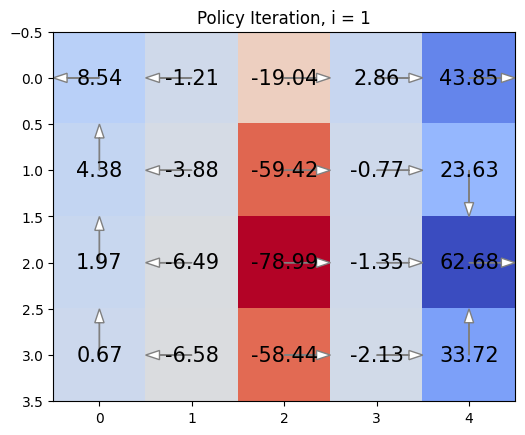

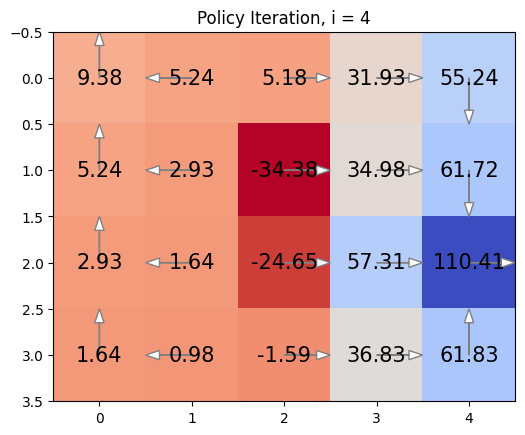

0.7755858898162842
Converged at iteration 4
Policy iteration complete.



In [142]:
print('Beginning policy iteration.')
learn_strategy(planning_type=POLICY_ITER, max_iter = 100, print_every = 100, ct = 0.01, gamma = 0.6)
print('Policy iteration complete.\n')

## Show Value Iteration

Beginning value iteration.


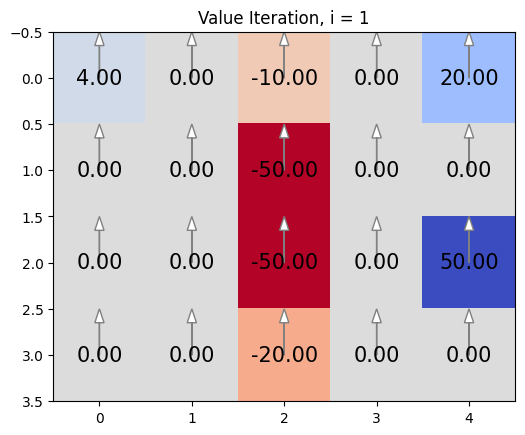

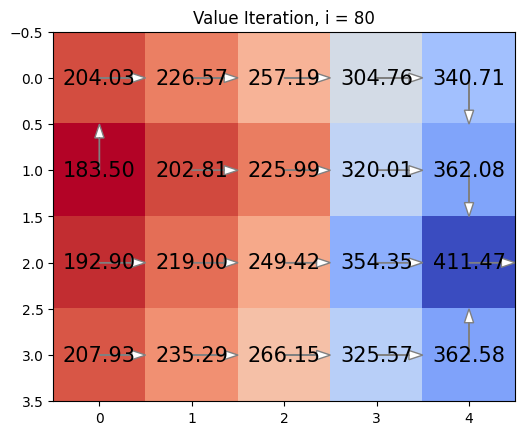

2.886244297027588
Converged at iteration 80
Value iteration complete.



In [146]:
print('Beginning value iteration.')
learn_strategy(planning_type=VALUE_ITER, max_iter = 100, print_every = 100, ct = 0.01, gamma = 0.9)
print('Value iteration complete.\n')

# Problem 3 

Make sure to install pygame (i.e. through running `pip install pygame`)

In [447]:
import numpy as np
import numpy.random as npr
import pygame as pg

# uncomment this for animation
# from p3src.SwingMonkey import SwingyMonkey

# uncomment this for no animation (use this for most purposes! it gets very slow otherwise)
from p3src.SwingMonkeyNoAnimation import SwingyMonkey

In [6]:
!pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 8.7 MB/s eta 0:00:0000:0100:01


In [148]:
# Some constants. Don't edit this!
X_BINSIZE = 200
Y_BINSIZE = 100
X_SCREEN = 1400
Y_SCREEN = 900

In [149]:
class RandomJumper(object):
    """
    This agent jumps randomly.
    """

    def __init__(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

        # We initialize our Q-value grid that has an entry for each action and state.
        # (action, rel_x, rel_y)
        self.Q = np.zeros((2, X_SCREEN // X_BINSIZE, Y_SCREEN // Y_BINSIZE))

    def reset(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

    def discretize_state(self, state):
        """
        Discretize the position space to produce binned features.
        rel_x = the binned relative horizontal distance between the monkey and the tree
        rel_y = the binned relative vertical distance between the monkey and the tree
        """

        rel_x = int((state["tree"]["dist"]) // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)
        return (rel_x, rel_y)

    def action_callback(self, state):
        """
        Implement this function to learn things and take actions.
        Return 0 if you don't want to jump and 1 if you do.
        """

        new_action = npr.rand() < 0.1
        new_state = state

        self.last_action = new_action
        self.last_state = new_state

        return self.last_action

    def reward_callback(self, reward):
        """This gets called so you can see what reward you get."""
        self.last_reward = reward

In [502]:
class Learner(object):
    """
    Implement this bot! A good start is to look at the skeleton of RandomJumper, which 
    frames the bot in a good way, but has poor learning logic.
    """

    def __init__(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None
        self.alpha = 0.7
        self.gamma = 0.9
        self.epsilon = 0.1
        self.iters = 0
        self.Q = np.zeros((2, X_SCREEN // X_BINSIZE, Y_SCREEN // Y_BINSIZE))

    def reset(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

    def discretize_state(self, state):
        """
        Discretize the position space to produce binned features.
        rel_x = the binned relative horizontal distance between the monkey and the tree
        rel_y = the binned relative vertical distance between the monkey and the tree
        """

        rel_x = int((state["tree"]["dist"]) // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)
        return (rel_x, rel_y)
    
     
     
        # if self.iters > 10:
            # self.epsilon = 0.2
        # if self.iters > 20:
            # self.epsilon = 0.1
        # if self.iters > 30:
            # self.epsilon = 0.5

    def action_callback(self, state):
        """
        Whenever the state changes, this function will be called.
        Return 0 if you don't want to jump and 1 if you do.
        """
        epsilon_min = 0.01
        epsilon_max = 0.11
        decay_rate = 0.01
        # print(state)
        # Discretize 'state' to get your transformed 'current state' features.
        self.iters += 1
        self.epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-decay_rate * self.iters)


        alpha_min = 0.01
        alpha_max = 0.7
        alpha_decay_rate = 0.0001
        self.alpha = alpha_min + (alpha_max - alpha_min) * np.exp(-alpha_decay_rate * self.iters)
        self.current_state = self.discretize_state(state)
        if self.last_action is None:
            self.last_action = npr.choice([0,1])

        if self.last_state is None:
            self.last_state = 0, 0

        if self.last_reward is None:
            self.last_reward = 0
        # Perform the Q-Learning update using 'current state' and the 'last state'.

        # print(self.last_state)
        max_Qprime = np.max(self.Q[:, self.current_state[0], self.current_state[1]])
        past_Q = self.Q[self.last_action, self.last_state[0], self.last_state[1]]

        brackets = self.last_reward + self.gamma * max_Qprime - past_Q
        self.Q[self.last_action, self.last_state[0], self.last_state[1]] += (
            self.alpha * brackets)
        

        # old = self.Q[self.last_action][x0][y0]
        
       # self.Q[self.last_action][x0][y0] = (1- self.alpha) * old + (
            # self.alpha * (self.last_reward)) + self.gamma * (
                # self.Q[best_action][x][y])

        # Choose the next action using an epsilon-greedy policy.
 
        if npr.rand() < (1 - self.epsilon):
            return_action = np.argmax(self.Q[:, self.current_state[0], self.current_state[1]])
        else:
            return_action = npr.choice([0, 1])
        self.last_action = return_action
        self.last_state = self.current_state
        # print(self.last_action)
        return self.last_action
            
       

    def reward_callback(self, reward):
        """
        When you are given a reward, this function is called.
        """
        # print(reward)
        self.last_reward = reward


        # print("old", old)
        # print("r", self.last_reward)
        # print("reward", self.reward_callback(self.last_reward))
        # print("max", self.Q[best_action][x][y])

In [430]:
def run_games(learner, hist, iters=100, t_len=100):
    """
    Driver function to simulate learning by having the agent play a sequence of games.
    """
    for ii in range(iters):
        # Make a new monkey object.
        swing = SwingyMonkey(sound=False,  # Don't play sounds.
                             text="Epoch %d" % (ii),  # Display the epoch on screen.
                             tick_length=t_len,  # Make game ticks super fast.
                             action_callback=learner.action_callback,
                             reward_callback=learner.reward_callback)

        # Loop until you hit something.
        while swing.game_loop():
            pass

        # Save score history.
        hist.append(swing.score)
        # print(hist)
        # Reset the state of the learner.
        learner.reset()
    pg.quit()
    return

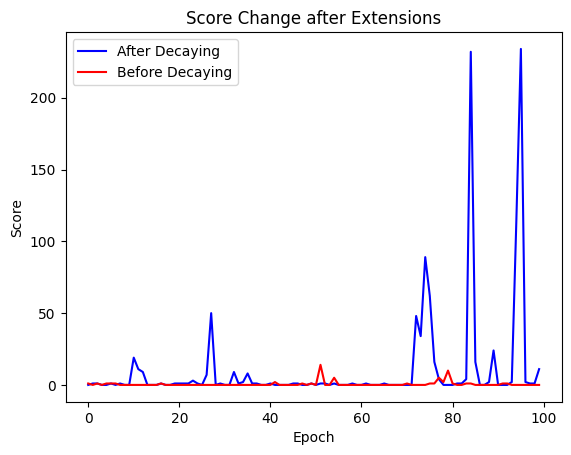

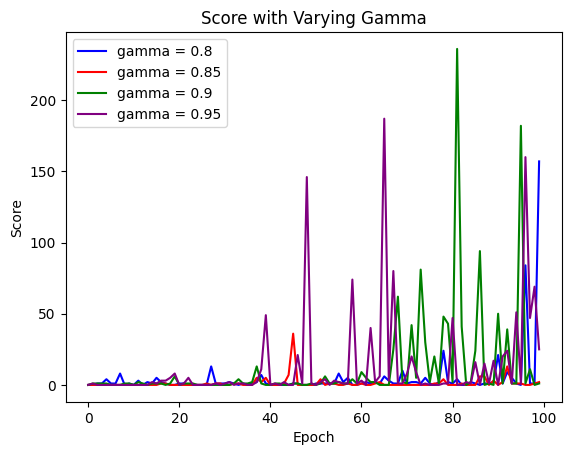

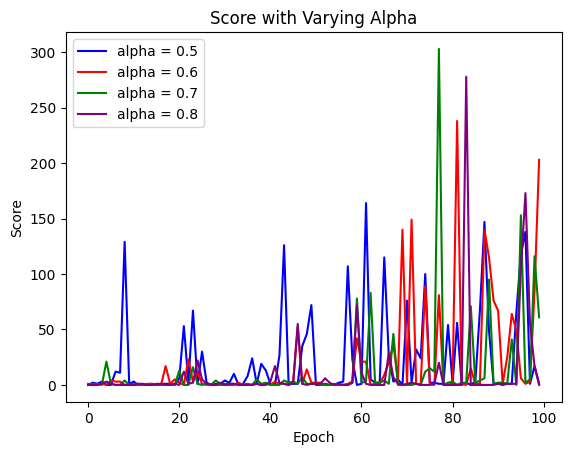

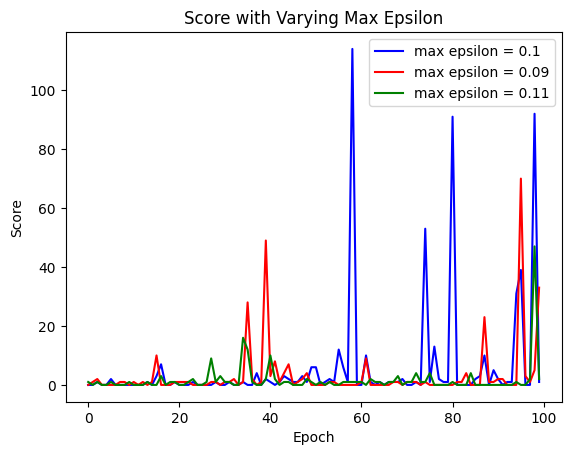

In [506]:
import matplotlib.pyplot as plt

# Example arrays of 100 scores
score_after = [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 19, 11, 9, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 3, 1, 0, 7, 50, 0, 1, 0, 0, 9, 1, 2, 8, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 48, 34, 89, 62, 16, 4, 0, 0, 0, 1, 1, 4, 232, 16, 0, 0, 2, 24, 0, 0, 0, 2, 114, 234, 2, 1, 1, 11]  # Replace this with your actual array of scores
score_before = [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 14, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 5, 2, 10, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]    # Another example array    # Another example array

# Plotting the scores with different colors
plt.plot(score_after, color='blue', label='After Decaying')
plt.plot(score_before, color='red', label='Before Decaying')
# plt.plot(scores3, color='green', label='Scores 3')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Score Change after Extensions')
plt.legend()  # Show legend with labels
plt.show()

gamma_eight = [0, 0, 1, 1, 4, 1, 1, 8, 0, 1, 0, 3, 0, 2, 1, 5, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 13, 1, 1, 1, 2, 1, 0, 1, 0, 1, 2, 7, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 8, 2, 5, 0, 0, 1, 2, 1, 2, 1, 6, 3, 1, 1, 10, 1, 2, 2, 1, 5, 1, 0, 2, 24, 2, 1, 4, 0, 0, 2, 1, 0, 1, 1, 2, 21, 1, 9, 5, 1, 0, 84, 1, 1, 157]
gamma_eighthalf = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 5, 2, 5, 0, 0, 0, 1, 7, 36, 0, 0, 0, 0, 0, 4, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0, 0, 1, 0, 0, 0, 6, 6, 0, 3, 0, 2, 13, 1, 1, 1, 0, 0, 1, 2]
gamma_nine = [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 6, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 1, 2, 13, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 6, 1, 1, 2, 1, 1, 4, 1, 9, 5, 2, 2, 0, 0, 0, 25, 62, 2, 1, 42, 5, 81, 30, 2, 20, 1, 48, 43, 2, 236, 41, 0, 2, 24, 94, 0, 1, 0, 50, 1, 39, 1, 1, 182, 1, 11, 0, 1]
gamma_ninehalf = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 3, 5, 8, 0, 1, 5, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 0, 0, 2, 11, 49, 0, 1, 0, 2, 0, 0, 21, 1, 146, 1, 0, 2, 4, 0, 3, 2, 1, 1, 74, 1, 3, 0, 40, 2, 6, 187, 3, 80, 1, 1, 8, 20, 9, 0, 1, 0, 0, 0, 1, 1, 47, 0, 0, 2, 1, 16, 0, 15, 1, 17, 0, 20, 24, 1, 51, 1, 160, 47, 69, 25]
# Plotting the scores with different colors
plt.plot(gamma_eight, color='blue', label='gamma = 0.8')
plt.plot(gamma_eighthalf, color='red', label='gamma = 0.85')
plt.plot(gamma_nine, color='green', label='gamma = 0.9')
plt.plot(gamma_ninehalf, color='purple', label='gamma = 0.95')
# plt.plot(scores3, color='green', label='Scores 3')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Score with Varying Gamma')
plt.legend()  # Show legend with labels
plt.show()

alpha_five = [0, 2, 1, 3, 0, 0, 12, 11, 129, 1, 3, 0, 0, 0, 1, 0, 1, 1, 1, 0, 6, 53, 3, 67, 1, 30, 2, 0, 1, 1, 4, 2, 10, 0, 1, 8, 24, 1, 19, 13, 1, 0, 27, 126, 1, 1, 1, 35, 46, 72, 0, 0, 1, 0, 0, 2, 3, 107, 23, 0, 1, 164, 5, 2, 2, 115, 26, 3, 5, 0, 76, 2, 32, 24, 100, 2, 2, 1, 1, 54, 1, 56, 0, 2, 0, 3, 67, 147, 49, 1, 1, 0, 1, 1, 65, 118, 138, 1, 17, 1]
alpha_six = [1, 0, 0, 1, 0, 4, 3, 3, 0, 0, 1, 1, 0, 1, 1, 0, 0, 17, 1, 5, 2, 0, 23, 3, 11, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 3, 1, 1, 0, 2, 52, 1, 14, 2, 2, 2, 0, 0, 1, 0, 0, 1, 3, 42, 21, 21, 0, 1, 1, 9, 20, 37, 4, 140, 1, 149, 1, 0, 89, 1, 0, 81, 0, 0, 2, 238, 1, 0, 15, 1, 1, 140, 115, 76, 67, 1, 25, 64, 49, 6, 1, 3, 85, 203]


alpha_seven = [0, 1, 1, 0, 21, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 16, 1, 0, 1, 0, 4, 1, 1, 1, 1, 0, 1, 0, 0, 5, 1, 2, 0, 0, 0, 4, 2, 3, 1, 7, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 78, 2, 3, 83, 2, 2, 4, 1, 46, 0, 0, 0, 0, 1, 0, 12, 15, 12, 303, 0, 2, 3, 0, 2, 2, 71, 2, 4, 6, 95, 1, 2, 2, 1, 41, 0, 153, 2, 5, 116, 61]
alpha_eight = [0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 12, 1, 2, 22, 5, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 3, 17, 2, 1, 0, 2, 55, 1, 0, 1, 1, 1, 6, 2, 0, 1, 0, 0, 2, 72, 11, 1, 0, 0, 0, 0, 29, 7, 1, 0, 1, 2, 1, 0, 0, 0, 1, 20, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 105, 173, 55, 17, 0]




# Plotting the scores with different colors
plt.plot(alpha_five, color='blue', label='alpha = 0.5')
plt.plot(alpha_six, color='red', label='alpha = 0.6')
plt.plot(alpha_seven, color='green', label='alpha = 0.7')
plt.plot(alpha_eight, color='purple', label='alpha = 0.8')
# plt.plot(scores3, color='green', label='Scores 3')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Score with Varying Alpha')
plt.legend()  # Show legend with labels
plt.show()

epsilon_one = [0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 7, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 4, 0, 2, 1, 0, 1, 3, 2, 1, 1, 3, 1, 6, 6, 0, 1, 2, 1, 12, 6, 1, 114, 0, 0, 10, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 53, 1, 13, 2, 1, 1, 91, 0, 0, 0, 0, 2, 3, 10, 0, 5, 2, 0, 1, 1, 31, 39, 0, 0, 92, 1]
epsilon_nine = [0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 10, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 28, 2, 0, 1, 49, 3, 8, 1, 4, 7, 0, 1, 2, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 9, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0, 0, 23, 1, 1, 2, 2, 0, 0, 0, 70, 3, 1, 5, 33]
epsilon_oneone = [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 3, 0, 1, 1, 0, 0, 1, 2, 0, 0, 1, 9, 1, 3, 1, 1, 0, 0, 16, 12, 1, 0, 0, 2, 10, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 3, 0, 1, 1, 4, 1, 1, 4, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 47, 2]


# Plotting the scores with different colors
plt.plot(epsilon_one, color='blue', label='max epsilon = 0.1')
plt.plot(epsilon_nine, color='red', label='max epsilon = 0.09')
plt.plot(epsilon_oneone, color='green', label='max epsilon = 0.11')
# plt.plot(scores3, color='green', label='Scores 3')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Score with Varying Max Epsilon')
plt.legend()  # Show legend with labels
plt.show()



In [505]:
# uncomment the agent you want to run.
agent = Learner()
# agent = RandomJumper()

# Empty list to save history.
hist = []

# Run games. You can update t_len to be smaller to run it faster.
run_games(agent, hist, 100, 100)
print(hist)

# Save history. 
np.save('hist', np.array(hist))

[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 3, 0, 1, 1, 0, 0, 1, 2, 0, 0, 1, 9, 1, 3, 1, 1, 0, 0, 16, 12, 1, 0, 0, 2, 10, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 3, 0, 1, 1, 4, 1, 1, 4, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 47, 2]
